# Applications with ConDynS

This notebook demonstrates how to apply ConDynS to analyze conversational dynamics, replicating the application results discussed in Section 6 of our [paper: A Similarity Measure for Comparing Conversational Dynamics](https://arxiv.org/abs/2507.18956). It includes examples of clustering conversations, comparing inter- and intra-group similarity, and examining which speaker drives the conversation’s dynamics. The notebook serves as a quick reference for using the metric on other datasets.

In [ ]:
import json
from convokit import Corpus, download
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import numpy as np
import re
import scipy.stats as stats
from itertools import combinations
from datetime import datetime
import os
import random
random.seed(4300)
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from scipy.stats import mannwhitneyu
import math
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.feature_extraction.text import CountVectorizer as CV
import string

from convokit.genai.genai_config import GenAIConfigManager
from convokit.convo_similarity.summary import SCDWriter
from convokit.convo_similarity.condyns import ConDynS

[nltk_data] Downloading package punkt to /home/kz88/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
### Setup path for data and corpus ###
DATA_PATH = "./data"

### Select which model provider to use for ConDynS ###
MODLE_PROVIDER = "gemini"

### Set up config for GenAI ###
config = GenAIConfigManager() ### make sure to set your own config if this is never set before

### Experiment Setup

We first focus on conversations from the ChangeMyView sub-Reddit. We need to annotate delta information for conversations to prepare for conversation selections later. We would also define methods to filter out invalid conversations.

In [ ]:
corpus = Corpus(filename=download("subreddit-changemyview", data_dir=DATA_PATH))

In [ ]:
### Annotate Corpus with Delta Information Based on DeltaBot ###
for utt in tqdm(corpus.iter_utterances()):
    if (
        utt.reply_to is not None
        and utt.speaker.id == "DeltaBot"
        and "delta awarded" in utt.text
    ):
        deltabot_text = utt.text
        match = re.search(
            r"(?:Confirmed: 1 delta awarded to )(?:\/)?(?:u\/)([\w-]+)", deltabot_text
        )
        if match is not None:
            try:
                delta_utt = corpus.get_utterance(utt.reply_to)
                delta_utt.meta['got_delta'] = True
            except KeyError:
                continue

5017556it [00:10, 495359.20it/s]


In [ ]:
### Remove Speakers that has delta / # convo ratio > 1 and had more than 10000 conversations (likely bots) ###
invalid_speakers = ['Cou', 'rightplacewr0ngtime', 'ThursdayTrashTyrant', 'UggoJesus', 'WideLight', 'urge_to_merge', 'LukeJovanovic'] + ['hacksoncode', 'Ansuz07', 'tbdabbholm'] 
### Remove Convos that contain toxic content which prevents model from processing ###
toxic_convos = ['unbvfc_d', 'cvs2dx_c', 'brshwd_d', 'vhmoje_b', 'qdd7k1_b', '3mhbgl_d', 'xr0bxq_b']

### Controlling for the length of the conversation ###
# def is_correct_length_convo(utt_lst, low_lim=5, high_lim=7):
#     num_of_utt = len(utt_lst)
#     return num_of_utt >= low_lim and num_of_utt <= high_lim
def is_correct_length_convo(utt_lst, low_lim=5):
    return len(utt_lst) >= low_lim

### Controlling for the number of speakers ###
def is_two_speaker_convo(utt_lst):
    speaker_lst = []
    for utt in utt_lst:
        if utt.speaker.id not in speaker_lst:
            speaker_lst.append(utt.speaker.id)
        if len(speaker_lst) > 2:
            return False
    return len(speaker_lst) == 2

### Filtering out invalid convos ###
def is_valid_convo(convo, utt_lst, invalid_sp=invalid_speakers, toxic_convo=toxic_convos):
    if convo.id in toxic_convo or not is_correct_length_convo(utt_lst) or not is_two_speaker_convo(utt_lst):
        return False

    for utt in utt_lst:
        if utt.speaker.id in invalid_sp:
            return False
    for utt in utt_lst:
        if utt.text == "[deleted]":
            return False
    return True

### Helper functions ###
def get_all_speakers(utt_lst):
    speaker_lst = []
    for utt in utt_lst:
        speaker_lst.append(utt.speaker.id)
    return speaker_lst

def get_convo_year(utt_lst):
    timestamp = utt_lst[1].meta['retrieved_on']
    time = datetime.utcfromtimestamp(timestamp)
    if time.year > 2014:
        return time.year
    else:
        for utt in utt_lst:
            timestamp = utt.meta['retrieved_on']
            time = datetime.utcfromtimestamp(timestamp)
            if time.year > 2014:
                return time.year
        return None

def read_convo(utt_lst):
    for utt in utt_lst:
        print(f"{utt.speaker.id} : {utt.text}\n")

### Select Conversations From Year of 2018

Our experiments are conducted on Reddit Data from 2018 so there is no LLM influence on contents. Now we filter out valid conversations from 2018, and select conversations from there.

In [ ]:
### Filtering out invalid conversations ###
random.seed(4300)
valid_convos = {}
for convo in tqdm(corpus.iter_conversations()):
    try:
        all_convos = convo.get_root_to_leaf_paths()
    except ValueError:
        continue
    cur_convo_valid_utts = []
    for utt_lst in all_convos:
        if is_valid_convo(convo, utt_lst):
            cur_convo_valid_utts.append(utt_lst)
    if cur_convo_valid_utts:
        cur_convo_utt_lst = random.choice(cur_convo_valid_utts)
        valid_convos[convo.id] = cur_convo_utt_lst

print("Number of valid convos:", len(valid_convos))

117492it [00:40, 2893.90it/s]


31760

In [ ]:
### Get year 2018 conversations ###
convo_to_year = {'2018' : []}
for convo_id, utt_lst in tqdm(valid_convos.items()):
    convo_year = get_convo_year(utt_lst)
    for year, _ in convo_to_year.items():
        if convo_year == int(year):
            convo_to_year[year].append(convo_id)
            break

for year, convos in convo_to_year.items():
    print(f"{year}: {len(convos)} conversations")

100%|█████████████████████████████████| 31760/31760 [00:00<00:00, 103967.04it/s]

2018: 7244 conversations


In [ ]:
### Select conversations from 2018 ###
random.seed(4300)
K = 220
used_speakers = []
selected_convos_each_year = {'2018' : []}
for year, convo_ids in tqdm(convo_to_year.items()):
    random.shuffle(convo_ids)
    for convo_id in convo_ids:
        convo_speakers = get_all_speakers(valid_convos[convo_id])
        
        if all(s not in used_speakers for s in convo_speakers):
            selected_convos_each_year[year].append(convo_id)
            used_speakers.extend(convo_speakers)
        
        if len(selected_convos_each_year[year]) == K:
            break

for year, convos in selected_convos_each_year.items():
    print(f"{year}: {len(convos)} conversations")

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 42.44it/s]

2018: 220 conversations


In [ ]:
### Counting the number of selected convos with delta ###
convo_2018 = [valid_convos[idx] for idx in selected_convos_each_year['2018']]
count = 0
for utt_lst in convo_2018:
    for utt in utt_lst:
        if 'got_delta' in utt.meta and utt.meta['got_delta']:
            count += 1
            break
print("Number of convos with delta:", count)

33

In [ ]:
### Constructing the corpus for selected conversations ###
all_utterances = []
for utt_lst in convo_2018:
    all_utterances.extend(utt_lst)

selected_corpus = Corpus(utterances=all_utterances)

In [ ]:
### Annotating the new corpus with metadata information ###
for convo in tqdm(selected_corpus.iter_conversations()):
    delta_convo = False
    for utt in convo.iter_utterances():
        if 'got_delta' in utt.meta and utt.meta['got_delta']:
            delta_convo = True
    og_convo = corpus.get_conversation(convo.id)
    convo.meta = og_convo.meta
    convo.meta['year'] = '2018'
    convo.meta['has_delta'] = delta_convo

for sp in tqdm(selected_corpus.iter_speakers()):
    og_sp = corpus.get_speaker(sp.id)
    sp.meta = og_sp.meta

220it [00:00, 10192.83it/s]
440it [00:00, 120581.10it/s]


In [ ]:
selected_corpus.dump("cmv_selected_convos_2018", base_path=DATA_PATH)

In [ ]:
with open(DATA_PATH + "cmv_selected_convo_ids_2018.json", "w") as f:
    json.dump(selected_convos_each_year['2018'], f, indent=4)

## ConDynS Computation - Random 2018 Set

In this section, we compute ConDynS scores for a randomly selected set of 2018 conversations. These scores form the basis for the subsequent analyses, including clustering and group-level comparisons.

In [ ]:
BASE_PATH = "./artefacts"
CUR_ANALYSIS = "random_set_2018"

if not os.path.exists(f"{BASE_PATH}"):
    print("Making directory: ", f"{BASE_PATH}")
    os.makedirs(f"{BASE_PATH}")

if not os.path.exists(f"{BASE_PATH}/{CUR_ANALYSIS}/"):
    print("Making directory: ", f"{BASE_PATH}/{CUR_ANALYSIS}/")
    os.makedirs(f"{BASE_PATH}/{CUR_ANALYSIS}/")

In [ ]:
with open(DATA_PATH + "cmv_selected_convo_ids_2018.json", "r") as f:
    convo_2018 = json.load(f)

corpus = Corpus(filename=DATA_PATH + "cmv_selected_convos_2018")

In [92]:
def get_cur_convo_transcript(corpus, convo_id):
    convo = corpus.get_conversation(convo_id)
    utt_list = convo.get_chronological_utterance_list()
    transcription = []
    spk_list = {utt_list[0].speaker.id : "SPEAKER1"}
    for utt in utt_list:
        if utt.speaker.id not in spk_list.keys():
            spk_list[utt.speaker.id] = "SPEAKER2"
            assert len(spk_list) == 2
        transcription.append(spk_list[utt.speaker.id] +": "+utt.text)
    transcription = transcription[1:] # remove first OP message
    return transcription

Here, we initialize our modules for writing the SCDs and computing ConDynS

In [ ]:
### Initialize the modules for ConDynS ###
scd_writer_gpt = SCDWriter(model_provider=MODLE_PROVIDER, config=config)
condyns_gpt = ConDynS(model_provider=MODLE_PROVIDER, config=config)

In [ ]:
def compute_within_group_similarity(all_convos, summaries_and_bullets, similarity_result, incomplete, data_path):
    """
    Compute the similarity between all conversations in the same group of conversations using ConDynS.
    This function is build with parallelization in mind to speed up the computation.
    """
    all_convos_combos = list(combinations(all_convos, 2))
    len(all_convos_combos)
    
    # ### Calling GPT to create the SCD and bullet points. Run with caution.
    summaries_and_bullets = summaries_and_bullets
    incomplete = incomplete
    similarity_result = similarity_result
    
    for convo_id in tqdm(all_convos, desc="generating SCDs"):
        if convo_id in summaries_and_bullets.keys(): continue
        summary, bulletpoint = scd_writer_gpt.get_scd_and_sop(corpus, convo_id)
        summaries_and_bullets.update({convo_id : {"summary" : summary, "bulletpoint" : bulletpoint}})
    with open(f"{data_path}summary.json", "w") as file:
        json.dump(summaries_and_bullets, file, indent=4)

    def get_bidirection_similarity_with_retry(corpus, convo1_id, convo2_id, summaries_and_bullets, retries=10):
        for i in range(retries):
            try:
                result = condyns_gpt.compute_bidirectional_similarity(corpus, convo1_id, convo2_id, summaries_and_bullets)
                score = condyns_gpt.compute_score_from_results(result)
                return score, result
            except Exception as e:
                wait = 0.5 ** i + random.random()
                print(f"Retrying ({convo1_id}, {convo2_id}) after {wait:.2f}s due to error: {e}")
                incomplete.append(f'{convo1_id}_{convo2_id}')
                time.sleep(wait)
        return None, None
    
    # The thread worker function
    def worker(corpus, convo1_id, convo2_id, summaries_and_bullets):
        score, result = get_bidirection_similarity_with_retry(corpus, convo1_id, convo2_id, summaries_and_bullets)
        return (f'{convo1_id}_{convo2_id}', {"score": score, "result": result})

    MAX_WORKER = 50
    
    # Build task list
    tasks = [(corpus, id1, id2, summaries_and_bullets) 
             for id1, id2 in all_convos_combos 
             if f'{id1}_{id2}' not in similarity_result and f'{id1}_{id2}' not in incomplete and f'{id2}_{id1}' not in similarity_result and f'{id2}_{id1}' not in incomplete]
        
    # Set up thread pool
    with ThreadPoolExecutor(max_workers=MAX_WORKER) as executor:
        futures = [executor.submit(worker, *task) for task in tasks]
    
        for future in tqdm(as_completed(futures), total=len(futures), desc="Computing Pair-wise Similarity"):
            key, value = future.result()
            if key in similarity_result.keys():
                print("not good, repeated keys")
            if key not in incomplete:
                similarity_result[key] = value

    with open(f"{data_path}similarity.json", "w") as file:
        json.dump(similarity_result, file, indent=4)

    with open(f"{data_path}incomplete.json", "w") as file:
        json.dump(incomplete, file, indent=4)

    return summaries_and_bullets, similarity_result, incomplete

In [ ]:
### Compute within-group similarity using ConDynS on selected 2018 conversations ###
all_convos = convo_2018
data_path = f"{BASE_PATH}/{CUR_ANALYSIS}/"

if os.path.exists(f"{data_path}summary.json"):
    with open(f"{data_path}summary.json", "r") as file:
        summaries_and_bullets = json.load(file)
else:
    summaries_and_bullets = {}

if os.path.exists(f"{data_path}similarity.json"):
    with open(f"{data_path}similarity.json", "r") as file:
        similarity_result = json.load(file)
else:
    similarity_result = {}

incomplete = []

summaries_and_bullets, similarity_result, incomplete = compute_within_group_similarity(all_convos, summaries_and_bullets, similarity_result, incomplete, data_path)

print("Complete!")

generating SCDs: 100%|████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1511460.90it/s]
Computing Pair-wise Similarity: 0it [00:00, ?it/s]


Complete!


In [ ]:
### Extract problematic conversations from the computation, expected to be [] ###
def extract_ids(id_list):
    id_count = {}
    for item in id_list:
        parts = item.split('_')
        mid = len(parts) // 2
        id1 = '_'.join(parts[:mid])
        id2 = '_'.join(parts[mid:])

        for id in [id1, id2]:
            if id not in id_count.keys():
                id_count[id] = 0
            id_count[id] += 1
    return id_count
problem_convos = [id for id, count in extract_ids(incomplete).items()]
problem_convos

[]

In [97]:
after_incomplete = [idx for idx in convo_2018 if idx not in problem_convos]
random.seed(4300)
convo_2018 = random.sample(after_incomplete, 200)
print(len(convo_2018))

200


## Analysis - Clustering

We use the computed ConDynS scores to cluster the conversation set into two groups and analyze their distinguishing interaction patterns (via fighting words) and the distribution of persuasion outcomes (Δ awards) across clusters.

In [ ]:
with open(DATA_PATH + "cmv_selected_convo_ids_2018.json", "r") as f:
    convo_2018 = json.load(f)

all_convos = convo_2018

In [ ]:
### Verify all similarity are computed valid here ###
with open(f"{data_path}summary.json", "r") as file:
    summaries_and_bullets = json.load(file)
for convo_id in all_convos:
    assert convo_id in summaries_and_bullets

with open(f"{data_path}similarity.json", "r") as file:
    similarity_result = json.load(file)
all_convos_combos = list(combinations(convo_2018, 2))
for id1, id2 in all_convos_combos:
    assert f'{id1}_{id2}' in similarity_result or f'{id2}_{id1}' in similarity_result

In [ ]:
### Helper functions to read in the results ###
def get_similarity(convo1, convo2, all_convos, sim_score):
    if convo1 not in all_convos or convo2 not in all_convos:
        raise Exception("convo not in selected convo")
    key = f"{convo1}_{convo2}" if f"{convo1}_{convo2}" in sim_score.keys() else f"{convo2}_{convo1}"
    score = sim_score[key]['score']
    return score


def compute_intra_group_similarity(group, sim_scores):
    similarities = []
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            sim = np.mean(get_similarity(group[i], group[j], group, sim_scores))
            similarities.append(sim)
    return np.array(similarities)


def two_groups_intra_group_similarity_check(group1, group2, group1_name, group2_name, all_convos, sim_score, y_lim=4):
    group1_similarities = compute_intra_group_similarity(group1, sim_score)
    group2_similarities = compute_intra_group_similarity(group2, sim_score)
    
    group1_mean = np.mean(group1_similarities)
    group2_mean = np.mean(group2_similarities)

    plt.figure(figsize=(6, 4))
    plt.hist(group1_similarities, bins=20, alpha=0.5, color='blue', label=f'{group1_name} convos', density=False)
    plt.hist(group2_similarities, bins=20, alpha=0.5, color='red', label=f'{group2_name} convos', density=False)
    
    plt.xlabel("similarity score")
    plt.ylabel("number of conversation pairs")
    # plt.title(f"Distribution of Similarity Scores for {group1_name} and {group2_name}")
    plt.legend()
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, 1)
    plt.ylim(0, y_lim)
    # plt.savefig("within-group-sim.png") ### Save figure for submissions
    
    plt.show()
    
    # Compare distributions with statistical tests
    t_stat, p_value = stats.ttest_ind(group1_similarities, group2_similarities, equal_var=False)
    levene_stat, levene_p = stats.levene(group1_similarities, group2_similarities)
    statistic, p_value = mannwhitneyu(group1_similarities, group2_similarities, alternative='two-sided')

    print(f"Mann-Whitney U statistic = {statistic}, p-value = {p_value:.5f}")
    
    # Print results
    print(f"{group1_name} Mean Similarity: {group1_mean:.4f}")
    print(f"{group2_name} Mean Similarity: {group2_mean:.4f}")
    print(f"T-Test p-value (Are means different?): {p_value:.4f}")
    print(f"Levene's Test p-value (Is variance different?): {levene_p:.4f}")


def compute_between_group_similarity(group1, group2, all_convos, sim_score):
    similarities = []
    for convo1 in group1:
        for convo2 in group2:
            sim = np.mean(get_similarity(convo1, convo2, all_convos, sim_score))
            similarities.append(sim)
    return np.array(similarities)
    

def between_group_similarity_check(group1, group2, group1_name, group2_name, all_convos, sim_score, y_lim=4):
    between_similarities = compute_between_group_similarity(group1, group2, all_convos, sim_score)
    
    between_mean = np.mean(between_similarities)
    
    plt.figure(figsize=(6, 4))
    plt.hist(between_similarities, bins=20, alpha=0.7, color='purple', label=f'{group1_name} vs {group2_name}', density=False)
    
    plt.xlabel("similarity score")
    plt.ylabel("number of conversation pairs")
    plt.title(f"Between-Group Similarity: {group1_name} vs {group2_name}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, 1)
    plt.ylim(0, y_lim)
    
    plt.show()
    
    print(f"Between-Group Mean Similarity ({group1_name} vs {group2_name}): {between_mean:.4f}")

def compute_intra_group_similarity_plot(group, group_name, sim_scores, y_lim=2000):
    similarities = []
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            sim = np.mean(get_similarity(group[i], group[j], group, sim_scores))
            similarities.append(sim)

    plt.figure(figsize=(6, 4))
    plt.hist(np.array(similarities), bins=20, alpha=0.5, color='red', label=f'{group_name}', density=False)
    
    plt.xlabel("similarity score")
    plt.ylabel("number of conversation pairs")
    # plt.title(f"Distribution of Similarity Scores for {group1_name} and {group2_name}")
    plt.legend()
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, 1)
    plt.ylim(0, y_lim)
    # plt.savefig("within-group-sim-random-set.png") ### Save figure for submissions
    print(np.mean(np.array(similarities)))
    
    plt.show()
    mean_val = np.mean(similarities)
    median_val = np.median(similarities)
    percentile_25 = np.percentile(similarities, 25)
    percentile_75 = np.percentile(similarities, 75)

    print(f"{group_name} Similarity Stats:")
    print(f"Mean:     {mean_val:.4f}")
    print(f"Median:   {median_val:.4f}")
    print(f"25th pct: {percentile_25:.4f}")
    print(f"75th pct: {percentile_75:.4f}")

0.3618311604852434


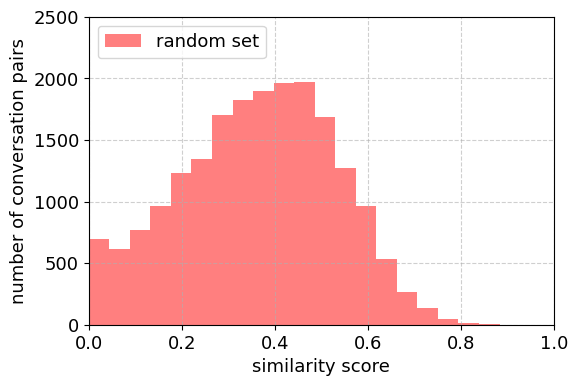

random set Similarity Stats:
Mean:     0.3618
Median:   0.3729
25th pct: 0.2444
75th pct: 0.4846


In [115]:
compute_intra_group_similarity_plot(convo_2018, "random set", similarity_result, y_lim=2500)

In [ ]:
### Helper functions for clustering conversations ###
from matplotlib import pyplot as plt

def cluster_conversations(convo_ids, threshold=5):
    """
    Performs hierarchical clustering on a list of conversation IDs based on pairwise similarity.
    
    Parameters:
    - convo_ids (list): List of conversation identifiers.
    
    Returns:
    - linkage_matrix (ndarray): Linkage matrix from hierarchical clustering.
    """
    n = len(convo_ids)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            convo1, convo2 = convo_ids[i], convo_ids[j]
            try:
                similarity = np.mean(get_similarity(convo1, convo2, convo_2018, similarity_result))
                distance = 1 - similarity
                distance_matrix[i, j] = distance_matrix[j, i] = distance
            except Exception as e:
                # distance_matrix[i, j] = distance_matrix[j, i] = 1  # Max distance if error
                print(e)

    condensed_dist_matrix = squareform(distance_matrix)
    linkage_matrix = linkage(condensed_dist_matrix, method="ward")

    cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')

    clusters = {}
    for convo, label in zip(convo_ids, cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(convo)
    
    cluster_lists = list(clusters.values())

    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, labels=convo_ids, leaf_rotation=90)
    plt.xlabel("Conversation ID")
    plt.ylabel("Distance")
    plt.show()

    # for i, cluster in enumerate(cluster_lists):
    #     print(f"Cluster {i+1}: {cluster}")
    
    return linkage_matrix, cluster_lists

exclude = set(string.punctuation)

# from https://github.com/jmhessel/FightingWords/blob/master/fighting_words_py3.py
def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''
    in_string = ''.join([ch for ch in in_string if ch not in exclude])
    in_string = in_string.lower()
    in_string = ' '.join(in_string.split())
    return in_string

def bayes_compare_language(l1, l2, ngram = 1, prior=.01, cv = None):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.

    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]
    if cv is None:
        cv = CV(decode_error = 'ignore', min_df=2, max_df=0.9, ngram_range=(1,ngram),
                binary = False,
                max_features = 15000)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v:k for k,v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = []
    for i in sorted_indices:
        return_list.append((index_to_term[i], z_scores[i]))
    return return_list

def format_bullet_points(bullets):
    text = ""
    for idx, bullet in bullets.items():
        text += f"{idx} : {bullet}\n"
    return text

def get_machine_scd_and_bullets(convo_id, scd_dict=summaries_and_bullets):
    summary = scd_dict[convo_id]['summary']
    bullet = format_bullet_points(scd_dict[convo_id]['bulletpoint'])
    return summary, bullet

def get_fighting_words_convincers(cluster1, cluster2):
    for lst in [cluster1, cluster2]:
        for convo_id in lst:
            summary, bullets = get_machine_scd_and_bullets(convo_id)
            convo = corpus.get_conversation(convo_id)
            convo.meta['new_machine_scd'] = summary
            convo.meta['machine_bullet_points'] = bullets
            sentences = sent_tokenize(summary)
            convincer_sentences = [s for s in sentences if 'CONVINCER' in s]
            convo.meta['new_convincer_text_machine_scd'] = " ".join(convincer_sentences)
            convo.meta['dict_bullet_points'] = dict(line.split(' : ', 1) for line in bullets.strip().split('\n'))
            convincer_bullets = ", ".join([s for _, s in convo.meta['dict_bullet_points'].items() if 'convincer' in s.lower()])
            convo.meta['convincer_bullet_points'] = convincer_bullets
    
    cluster1_convincer_scds = []
    cluster2_convincer_scds = []
    for convo_id in cluster1:
        convo = corpus.get_conversation(convo_id)
        # cluster1_convincer_scds.append(convo.meta['new_convincer_text_machine_scd'])
        cluster1_convincer_scds.append(convo.meta['convincer_bullet_points'])
    for convo_id in cluster2:
        convo = corpus.get_conversation(convo_id)
        # cluster2_convincer_scds.append(convo.meta['new_convincer_text_machine_scd'])
        cluster2_convincer_scds.append(convo.meta['convincer_bullet_points'])
    
    # z_scores = bayes_compare_language(cluster1_scds, cluster2_scds, ngram = 3)  # notice that save_file function is commented above, no file will be saved unless changed
    z_scores = bayes_compare_language(cluster1_convincer_scds, cluster2_convincer_scds, ngram = 3) 
    top_k = 10
    top_k_class1 = list(reversed([(x[0], round(x[1],2)) for x in z_scores[-top_k:]]))
    top_k_class2 = [(x[0], round(x[1],2)) for x in z_scores[:top_k]]
    top_k_class1 = list(reversed([(x[0], round(x[1],2)) for x in z_scores[-top_k:]]))
    top_k_class2 = [(x[0], round(x[1],2)) for x in z_scores[:top_k]]
    print(f"Fighting Words Comments between:")
    print("Cluster1: ", top_k_class1)
    print("Cluster2: ", top_k_class2)

def get_fighting_words_matching_bullets(cluster1, cluster2, similarity_result=similarity_result, summaries_and_bullets=summaries_and_bullets):
    cluster1_combo = list(combinations(cluster1, 2))
    matched_cluster1 = []
    for convo_id1, convo_id2 in cluster1_combo:
        key = f"{convo_id1}_{convo_id2}" if f"{convo_id1}_{convo_id2}" in similarity_result.keys() else f"{convo_id2}_{convo_id1}"
        for k, result in enumerate(similarity_result[key]['result']):
            for index in result:
                if result[index]['score'] > 0.5:
                    if k == 0:
                        matched_cluster1.append(summaries_and_bullets[convo_id1]['bulletpoint'][index])
                    else:
                        try:
                            matched_cluster1.append(summaries_and_bullets[convo_id2]['bulletpoint'][index])
                        except Exception:
                            continue
                        
    cluster2_combo = list(combinations(cluster2, 2))
    matched_cluster2 = []
    for convo_id1, convo_id2 in cluster2_combo:
        key = f"{convo_id1}_{convo_id2}" if f"{convo_id1}_{convo_id2}" in similarity_result.keys() else f"{convo_id2}_{convo_id1}"
        for k, result in enumerate(similarity_result[key]['result']):
            for index in result:
                if result[index]['score'] > 0.5:
                    if k == 0:
                        matched_cluster2.append(summaries_and_bullets[convo_id1]['bulletpoint'][index])
                    else:
                        matched_cluster2.append(summaries_and_bullets[convo_id2]['bulletpoint'][index])
    
    z_scores = bayes_compare_language(matched_cluster1, matched_cluster2, ngram = 3) 
    top_k = 15
    top_k_class1 = list(reversed([(x[0], round(x[1],2)) for x in z_scores[-top_k:]]))
    top_k_class2 = [(x[0], round(x[1],2)) for x in z_scores[:top_k]]
    top_k_class1 = list(reversed([(x[0], round(x[1],2)) for x in z_scores[-top_k:]]))
    top_k_class2 = [(x[0], round(x[1],2)) for x in z_scores[:top_k]]
    print(f"Fighting Words Comments between:")
    print("Cluster1: ", top_k_class1)
    print("Cluster2: ", top_k_class2)
    return matched_cluster1, matched_cluster2


def find_keywords_in_lst_of_text(lst, keyword):
    result = []
    for text in lst:
        if keyword.lower() in text.lower():
            result.append(text)
    return result
    

def get_clusters_delta_percentage(lst_of_clusters):
    for i, g in enumerate(lst_of_clusters):
        temp = []
        for idx in g:
            if corpus.get_conversation(idx).meta['has_delta']:
                temp.append("delta")
            else:
                temp.append("no")
        print(f"Cluster {i+1} (N={len(g)}): {temp.count('delta') / len(temp)}")

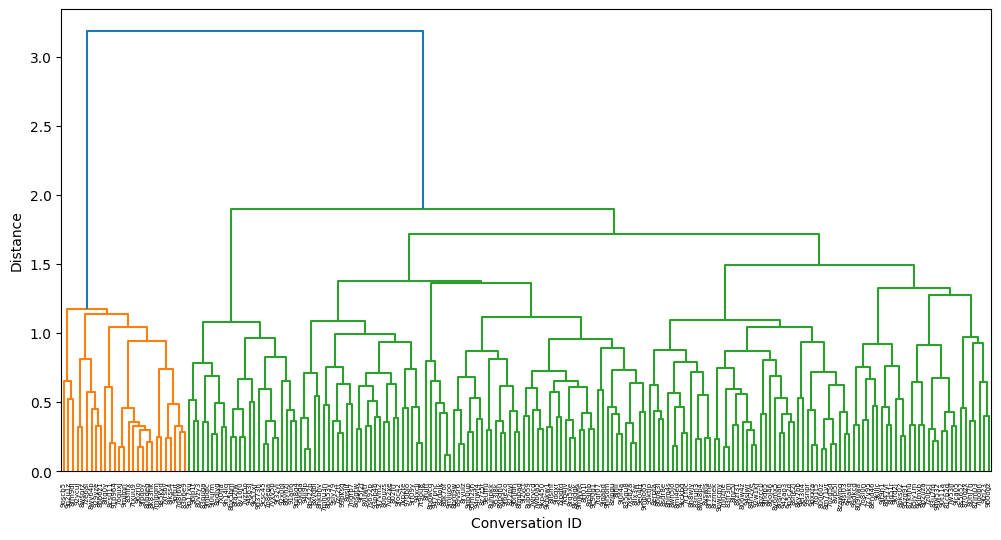

Cluster 1 (N=173): 0.057803468208092484
Cluster 2 (N=27): 0.6666666666666666


In [ ]:
### Cluster conversations, and we notice one cluster contains much more delta convos than the other, percentage wise ###
_, c_lst = cluster_conversations(convo_2018, threshold=2.5)
get_clusters_delta_percentage(c_lst)

In [59]:
print(c_lst[0])
print(len(c_lst[0]))

['9n5c2d', '947pnc', '8s5652', '8d47vl', '8osgtw', '8hx5bm', '7wb0a5', '7ozg5d', '9rf09y', '7xsb2a', '9euffu', '9jdqxr', '9mwvle', '7yxv5p', '9qb0up', '80puzs', '8ky7bb', '9e04tt', '9d373h', '7kp2te', '7lqobn', '9kjmxb', '9mbo65', '8xvqbl', '87knhu', '8lnr5l', '8yswls', '802frf', '7o8l0n', '9n17xu', '9j2vct', '8lfjli', '91ati6', '8up659', '8end46', '8qsjif', '8llx3w', '9bnjdh', '8ta2fw', '7x0ifa', '9j0urm', '7tqf07', '8fmbad', '94ij9p', '82dojk', '822pyi', '9foc42', '8him4s', '99dkcq', '8vpl5i', '9f5f2f', '8xzf31', '90t11a', '7wrvcd', '8zawmq', '9h14lq', '835qu8', '83u7fq', '95m2sh', '7w53lf', '8tf01l', '9lca05', '86yhzl', '86p83l', '7vo2xe', '970blo', '9lzi23', '8erpta', '8rq5xe', '8p2uza', '95ktip', '8h422p', '80060z', '7zc2tt', '99snpr', '8y6mx5', '8brd9w', '7kb4jv', '8pzcc0', '9i0f4a', '94slwr', '8rzmek', '7ngrb7', '8xpqnu', '9el3u4', '8g9jhb', '94si03', '8h8wjy', '92x0oi', '86oj46', '93pb46', '7mhu3n', '8wn5jo', '9khkw1', '9f32yj', '8oks02', '9csc45', '7xppfd', '8yuwtf', '9kckbq',

In [60]:
print(c_lst[1])
print(len(c_lst[1]))

['929yze', '92ycuj', '96zrio', '8wv64p', '9n2u1z', '7oquxj', '7mlpgm', '8cs011', '7xrsby', '9mjmri', '985kyd', '9oftut', '7q8r6w', '80hqeg', '83b6e9', '7txuu9', '91p964', '83fifx', '8wsnrz', '8ltq0y', '8k83hk', '9oscb5', '9fpqoy', '8ikss4', '7ze6ai', '8fm9dl', '8ob6z1']
27


In [121]:
random_2018_less_delta_set = ['9n5c2d', '947pnc', '8s5652', '8d47vl', '8osgtw', '8hx5bm', '7wb0a5', '7ozg5d', '9rf09y', '7xsb2a', '9euffu', '9jdqxr', '9mwvle', '7yxv5p', '9qb0up', '80puzs', '8ky7bb', '9e04tt', '9d373h', '7kp2te', '7lqobn', '9kjmxb', '9mbo65', '8xvqbl', '87knhu', '8lnr5l', '8yswls', '802frf', '7o8l0n', '9n17xu', '9j2vct', '8lfjli', '91ati6', '8up659', '8end46', '8qsjif', '8llx3w', '9bnjdh', '8ta2fw', '7x0ifa', '9j0urm', '7tqf07', '8fmbad', '94ij9p', '82dojk', '822pyi', '9foc42', '8him4s', '99dkcq', '8vpl5i', '9f5f2f', '8xzf31', '90t11a', '7wrvcd', '8zawmq', '9h14lq', '835qu8', '83u7fq', '95m2sh', '7w53lf', '8tf01l', '9lca05', '86yhzl', '86p83l', '7vo2xe', '970blo', '9lzi23', '8erpta', '8rq5xe', '8p2uza', '95ktip', '8h422p', '80060z', '7zc2tt', '99snpr', '8y6mx5', '8brd9w', '7kb4jv', '8pzcc0', '9i0f4a', '94slwr', '8rzmek', '7ngrb7', '8xpqnu', '9el3u4', '8g9jhb', '94si03', '8h8wjy', '92x0oi', '86oj46', '93pb46', '7mhu3n', '8wn5jo', '9khkw1', '9f32yj', '8oks02', '9csc45', '7xppfd', '8yuwtf', '9kckbq', '9bjp1t', '89vsr6', '95klqa', '83run3', '9sly79', '94nwf4', '7o8ega', '8ppwcq', '9b0ogz', '83puga', '85jy1m', '8qk7of', '80vzy3', '8hkbhv', '8sdr8e', '8uhpkk', '7r1f0c', '9nn8g4', '8nsnah', '9jqabd', '9dxxra', '94xcjj', '94w532', '7t9ou8', '9hrsom', '870qzx', '8r7sme', '7z7v95', '8v16f0', '7vzr5o', '9owcmy', '8ba53v', '806w4z', '8m71vr', '7nnzhe', '9jf9h1', '8z7z5t', '99bksq', '81cb2d', '9i7vm2', '8fujff', '95zg91', '953j8k', '9kp450', '84n2ye', '9f6e2o', '8sne2j', '9hjakq', '8ryulz', '8mi4eg', '9mbqic', '9jndp5', '8kqdgk', '92w1kf', '83fr3m', '94s63j', '80hj7h', '87im03', '8ilsmf', '942ao3', '8u9uwa', '7z0bcj', '9c90g1', '9k57xr', '8odjyg', '9klljc', '9kfd2l', '7to1t5', '8ld51r', '8wu8p4', '8zjpgu', '7s692p', '9mjuoo']
random_2018_more_delta_set = ['929yze', '92ycuj', '96zrio', '8wv64p', '9n2u1z', '7oquxj', '7mlpgm', '8cs011', '7xrsby', '9mjmri', '985kyd', '9oftut', '7q8r6w', '80hqeg', '83b6e9', '7txuu9', '91p964', '83fifx', '8wsnrz', '8ltq0y', '8k83hk', '9oscb5', '9fpqoy', '8ikss4', '7ze6ai', '8fm9dl', '8ob6z1']

In [ ]:
with open(DATA_PATH + "random_2018_less_delta_set.json", "w") as f:
    json.dump(random_2018_less_delta_set, f, indent=4)

with open(DATA_PATH + "random_2018_more_delta_set.json", "w") as f:
    json.dump(random_2018_more_delta_set, f, indent=4)

#### FightingWords

To interpret these clusters, we apply a fighting words analysis, identifying key words that most distinguish one cluster’s dynamics from the other.

In [ ]:
cluster1 = [summaries_and_bullets[convo_id]['summary'] for convo_id in random_2018_more_delta_set]
cluster2 = [summaries_and_bullets[convo_id]['summary'] for convo_id in random_2018_less_delta_set]

df = bayes_compare_language(cluster1, cluster2, ngram = 2)

print("Top 20 words in fighting words between Cluster 1 and Cluster 2: \n", df[:20])
print("Last 20 words in fighting words between Cluster 2 and Cluster 1: \n", df[-20:])

## Selecting Delta Conversations

Next, we sample a set of Δ (persuasive) and ¬Δ (non-persuasive) conversations and compare their similarity to the previously clustered groups, examining how ConDynS captures alignment between known persuasive dynamics and automatically discovered clusters.

In [ ]:
### First, we need to download the annotated CMV corpus ###
### TODO: Publish the annotated CMV corpus

corpus = Corpus(filename=DATA_PATH + "annotated_cmv_delta")

In [ ]:
### Helper functions ###
def is_delta_convo(convo):
    return convo.meta['has_delta']


def check_only_one_delta(convo1, convo2):
    return convo1.meta['has_delta'] + convo2.meta['has_delta'] == 1


def check_both_convo_valid(convo1, convo2, convo_2018=convo_2018):
    utt_lst1 = [utt for utt in convo1.iter_utterances()]
    utt_lst2 = [utt for utt in convo2.iter_utterances()]
    return is_valid_convo(convo1, utt_lst1) and is_valid_convo(convo2, utt_lst2) and extract_real_id(convo1.id) not in convo_2018 and extract_real_id(convo2.id) not in convo_2018


def extract_real_id(idx):
    return idx.split("_")[0]

In [ ]:
### Filtering for delta and non-delta convos in the year of 2018 ###
valid_convos = {"delta" : [], "no_delta" : []}

for convo in tqdm(corpus.iter_conversations()):
    if convo.id in valid_convos['delta'] or convo.id in valid_convos['no_delta']:
        continue
    pair = corpus.get_conversation(convo.meta['pair_id'])
    assert check_only_one_delta(convo, pair), "convo and its pair should have only one delta."
    if check_both_convo_valid(convo, pair):
        if get_convo_year([utt for utt in convo.iter_utterances()]) == 2018 and get_convo_year([utt for utt in pair.iter_utterances()]) == 2018:
            if convo.meta['has_delta']:
                assert not pair.meta['has_delta']
                valid_convos['delta'].append(convo.id)
                valid_convos['no_delta'].append(pair.id)
            else:
                assert not convo.meta['has_delta']
                valid_convos['delta'].append(pair.id)
                valid_convos['no_delta'].append(convo.id)

print("Number of delta convos: ", len(valid_convos['delta']))

12258it [00:00, 15214.59it/s]


818

In [ ]:
### Pairing up delta and non-delta convos ###
valid_convo_pairs = [(valid_convos['delta'][i], valid_convos['no_delta'][i]) for i in range(len(valid_convos['delta']))]

In [ ]:
### Select pairs of delta and non-delta convos, with unique speakers ###
random.seed(4300)
K = 250
used_speakers = []
selected_convos = []
random.shuffle(valid_convo_pairs)
for convo1, convo2 in tqdm(valid_convo_pairs):
    convo_1, convo_2 = corpus.get_conversation(convo1), corpus.get_conversation(convo2)
    utt_lst1, utt_lst2 = [utt for utt in convo_1.iter_utterances()], [utt for utt in convo_2.iter_utterances()]
    convo_speakers = list(set(get_all_speakers(utt_lst1) + get_all_speakers(utt_lst2)))
        
    if all(s not in used_speakers for s in convo_speakers):
        selected_convos.append(convo1)
        selected_convos.append(convo2)
        used_speakers.extend(convo_speakers)
        
    if len(selected_convos) == K:
        break

len(selected_convos)

 28%|██████████▊                           | 232/818 [00:00<00:00, 43716.18it/s]


250

In [ ]:
### Constructing the corpus with selected convos for the experiment ###
all_utterances = []
for convo_id in selected_convos:
    convo = corpus.get_conversation(convo_id)
    utt_lst = [utt for utt in convo.iter_utterances()]
    all_utterances.extend(utt_lst)

selected_corpus = Corpus(utterances=all_utterances)

In [ ]:
### Annotating the corpus ###
for convo in tqdm(selected_corpus.iter_conversations()):
    og_convo = corpus.get_conversation(convo.id)
    convo.meta = og_convo.meta
    convo.meta['year'] = '2018'

for sp in tqdm(selected_corpus.iter_speakers()):
    og_sp = corpus.get_speaker(sp.id)
    sp.meta = og_sp.meta

250it [00:00, 38280.37it/s]
375it [00:00, 176290.52it/s]


In [ ]:
selected_corpus.dump("cmv_selected_delta_2018", base_path=DATA_PATH)

In [ ]:
with open(DATA_PATH + "cmv_selected_delta_convo_ids_2018.json", "w") as f:
    json.dump(selected_convos, f, indent=4)

## ConDynS Computation - Delta 2018 Set

We compute ConDynS similarity scores within the Δ (persuasive) and ¬Δ (non-persuasive) sets.

In [ ]:
BASE_PATH = "./artefacts"
CUR_ANALYSIS = "delta_set_2018"

if not os.path.exists(f"{BASE_PATH}"):
    print("Making directory: ", f"{BASE_PATH}")
    os.makedirs(f"{BASE_PATH}")

if not os.path.exists(f"{BASE_PATH}/{CUR_ANALYSIS}/"):
    print("Making directory: ", f"{BASE_PATH}/{CUR_ANALYSIS}/")
    os.makedirs(f"{BASE_PATH}/{CUR_ANALYSIS}/")

In [ ]:
with open(DATA_PATH + "cmv_selected_delta_convo_ids_2018.json", "r") as f:
    delta_2018 = json.load(f)

len(delta_2018)

In [ ]:
corpus = Corpus(filename=DATA_PATH + "cmv_selected_delta_2018")

In [ ]:
### Check the distribution of the number of utterances in the corpus ###
from collections import Counter
numbers = [len(convo.get_utterance_ids()) for convo in corpus.iter_conversations()]
counts = Counter(numbers)
print(counts)

Counter({5: 156, 7: 56, 9: 22, 11: 7, 13: 6, 6: 2, 15: 1})


In [ ]:
### Computing the similarity between all conversations in the same group for delta 2018 selected convos ###
all_convos = delta_2018
data_path = f"{BASE_PATH}/{CUR_ANALYSIS}/"

if os.path.exists(f"{data_path}summary.json"):
    with open(f"{data_path}summary.json", "r") as file:
        summaries_and_bullets = json.load(file)
else:
    summaries_and_bullets = {}

if os.path.exists(f"{data_path}similarity.json"):
    with open(f"{data_path}similarity.json", "r") as file:
        similarity_result = json.load(file)
else:
    similarity_result = {}

incomplete = []

summaries_and_bullets, similarity_result, incomplete = compute_within_group_similarity(all_convos, summaries_and_bullets, similarity_result, incomplete, data_path)

print("Complete!")

In [ ]:
### Check completed computation ###
after_incomplete = [idx for idx in delta_2018 if idx not in problem_convos]
delta_set = [convo_id for convo_id in after_incomplete if corpus.get_conversation(convo_id).meta['has_delta']]
no_delta_set = [convo_id for convo_id in after_incomplete if convo_id not in delta_set]
print(len(delta_set), len(no_delta_set))
random.seed(4300)
delta_set = random.sample(delta_set, 100)
no_delta_set = random.sample(no_delta_set, 100)
delta_2018 = delta_set + no_delta_set
print(len(delta_2018))

125 125
200


# Compute Inter Group Similarity

We use ConDynS to measure inter-group similarity between the random conversation set and the delta groups. This shows how similar the dynamics of random conversations are to those of persuasive ones, helping us understand what the earlier clusters actually capture.

Here, we also demonstrate the way to set custom SCD prompts for adapting our module to your own data!



In [ ]:
BASE_PATH = "./artefacts"
CUR_ANALYSIS = "inter_group_sim"

if not os.path.exists(f"{BASE_PATH}"):
    print("Making directory: ", f"{BASE_PATH}")
    os.makedirs(f"{BASE_PATH}")

if not os.path.exists(f"{BASE_PATH}/{CUR_ANALYSIS}/"):
    print("Making directory: ", f"{BASE_PATH}/{CUR_ANALYSIS}/")
    os.makedirs(f"{BASE_PATH}/{CUR_ANALYSIS}/")

with open("cmv_selected_delta_convo_ids_2018.json", "r") as f:
    delta_2018 = json.load(f)

with open("cmv_selected_convo_ids_2018.json", "r") as f:
    convo_2018 = json.load(f)

In [ ]:
corpus_delta = Corpus(filename=DATA_PATH + "cmv_selected_delta_2018")
corpus_2018 = Corpus(filename=DATA_PATH + "cmv_selected_convos_2018")

In [4]:
delta_set = [convo_id for convo_id in delta_2018 if corpus_delta.get_conversation(convo_id).meta['has_delta']]
no_delta_set = [convo_id for convo_id in delta_2018 if convo_id not in delta_set]
assert len(delta_set) == len(no_delta_set) == 100

In [ ]:
with open(DATA_PATH + "random_2018_less_delta_set.json", "r") as f:
    random_2018_less_delta_set = json.load(f)

with open(DATA_PATH + "random_2018_more_delta_set.json", "r") as f:
    random_2018_more_delta_set = json.load(f)

In [ ]:
### Modify to SCD prompt to focus on Persuasions ###
persuasion_scd_prompt = """Write a short summary capturing the trajectory of an online conversation.  
Do not include specific topics, claims, or arguments from the conversation. The style you should avoid: 
Example Sentence 1: "Speaker1, who is Asian, defended Asians and pointed out that a study found that whites, Hispanics, and blacks were accepted into universities in that order, with Asians being accepted the least. Speaker2 acknowledged that Asians have high household income, but argued that this could be a plausible explanation for the study's findings. Speaker1 disagreed and stated that the study did not take wealth into consideration." 
This style mentions specific claims and topics, which are not needed.

Instead, do include indicators of sentiments (e.g., sarcasm, passive-aggressive, polite, frustration, attack, blame), individual intentions (e.g., agreement, disagreement, persistent-agreement, persistent-disagreement, rebuttal, defense, concession, confusion, clarification, neutral, accusation) and conversational strategies (if any) such as 'rhetorical questions', 'straw man fallacy', 'identify fallacies',  and 'appealing to emotions.' 
The following sentences demonstrate the style you should follow:

Example Sentence 2: "Both speakers have differing opinions and appeared defensive. Speaker1 attacks Speaker2 by diminishing the importance of his argument and Speaker2 blames Speaker1 for using profane words. Both speakers accuse each other of being overly judgemental of their personal qualities rather than arguments."

Example Sentence 3: "The two speakers refuted each other with back and forth accusations. Throughout the conversation, they kept harshly fault-finding with overly critical viewpoints, creating an intense and inefficient discussion."

Example Sentence 4: "Speaker1 attacks Speaker2 by questioning the relevance of his premise and Speaker2 blames Speaker1 for using profane words. Both speakers accuse each other of being overly judgemental of their personal qualities rather than arguments."

Overall, the trajectory summary should capture the key moments where the tension of the conversation notably changes. Here is an example of a complete trajectory summary. 

Trajectory Summary: 
Multiple users discuss minimum wage. Four speakers express their different points of view subsequently, building off of each other's arguments. Speaker1 disagrees with a specific point from Speaker2's argument, triggering Speaker2 to contradict Speaker1 in response. Then, Speaker3 jumps into the conversation to support Speaker1's argument, which leads Speaker2 to adamantly defend their argument. Speaker2 then quotes a deleted comment, giving an extensive counterargument. The overall tone remains civil.

Now, provide the trajectory summary for the following conversation.
Conversation Transcript:
{transcript}

Now, summarize this conversation. Remember, do not include specific topics, claims, or arguments from the conversation. Instead, try to capture the speakers' sentiments, intentions, and conversational/persuasive strategies. Limit the trajectory summary to 80 words. 

Trajectory Summary:
"""

persuasion_scd_writer = SCDWriter(
    model_provider="gpt",
    config=config,
    custom_scd_prompt=persuasion_scd_prompt,
    custom_prompt_dir="../../prompts/custom_prompts/"
)

In [ ]:
### Update helper functions with persuasion prompt ###
def get_cur_convo_transcript_persuasion(corpus, convo_id):
    convo = corpus.get_conversation(convo_id)
    utt_list = convo.get_chronological_utterance_list()
    transcription = []
    spk_list = {utt_list[0].speaker.id : "SPEAKER1"}
    for utt in utt_list:
        if utt.speaker.id not in spk_list.keys():
            spk_list[utt.speaker.id] = "SPEAKER2"
            assert len(spk_list) == 2
        transcription.append(spk_list[utt.speaker.id] +": "+utt.text)
    transcription = transcription[1:] # remove first OP message
    return transcription


def compute_within_group_similarity_persuasion(all_convos, summaries_and_bullets, similarity_result, incomplete, data_path):
    all_convos_combos = list(combinations(all_convos, 2))
    len(all_convos_combos)
    
    # ### Calling GPT to create the SCD and bullet points. Run with caution.
    summaries_and_bullets = summaries_and_bullets
    incomplete = incomplete
    similarity_result = similarity_result
    
    for convo_id in tqdm(all_convos, desc="generating SCDs"):
        if convo_id in summaries_and_bullets.keys(): continue
        summary, bulletpoint = persuasion_scd_writer.get_scd_and_sop(corpus_2018, corpus_delta, convo_id)
        summaries_and_bullets.update({convo_id : {"summary" : summary, "bulletpoint" : bulletpoint}})
    with open(f"{data_path}summary.json", "w") as file:
        json.dump(summaries_and_bullets, file, indent=4)

    def get_bidirection_similarity_with_retry_2(corpus_2018, corpus_delta, convo1_id, convo2_id, summaries_and_bullets, retries=10):
        for i in range(retries):
            try:
                result = condyns_gpt.compute_bidirectional_similarity(corpus_2018, corpus_delta, convo1_id, convo2_id, summaries_and_bullets)
                score = condyns_gpt.compute_score_from_results(result)
                return score, result
            except Exception as e:
                wait = 0.5 ** i + random.random()
                print(f"Retrying ({convo1_id}, {convo2_id}) after {wait:.2f}s due to error: {e}")
                incomplete.append(f'{convo1_id}_{convo2_id}')
                time.sleep(wait)
        return None, None
    
    # The thread worker function
    def worker(corpus_2018, corpus_delta, convo1_id, convo2_id, summaries_and_bullets):
        score, result = get_bidirection_similarity_with_retry_2(corpus_2018, corpus_delta, convo1_id, convo2_id, summaries_and_bullets)
        return (f'{convo1_id}_{convo2_id}', {"score": score, "result": result})

    MAX_WORKER = 50
    
    # Build task list
    tasks = [(corpus_2018, corpus_delta, id1, id2, summaries_and_bullets) 
             for id1, id2 in all_convos_combos 
             if f'{id1}_{id2}' not in similarity_result and f'{id1}_{id2}' not in incomplete and f'{id2}_{id1}' not in similarity_result and f'{id2}_{id1}' not in incomplete]
        
    # Set up thread pool
    with ThreadPoolExecutor(max_workers=MAX_WORKER) as executor:
        futures = [executor.submit(worker, *task) for task in tasks]
    
        for future in tqdm(as_completed(futures), total=len(futures), desc="Computing Pair-wise Similarity"):
            key, value = future.result()
            if key in similarity_result.keys():
                print("not good, repeated keys")
            if key not in incomplete:
                similarity_result[key] = value

    with open(f"{data_path}similarity.json", "w") as file:
        json.dump(similarity_result, file, indent=4)

    with open(f"{data_path}incomplete.json", "w") as file:
        json.dump(incomplete, file, indent=4)

    return summaries_and_bullets, similarity_result, incomplete

In [ ]:
all_convos = convo_2018 + delta_2018
data_path = f"{BASE_PATH}/{CUR_ANALYSIS}/"

if os.path.exists(f"{data_path}summary.json"):
    with open(f"{data_path}summary.json", "r") as file:
        summaries_and_bullets = json.load(file)
else:
    summaries_and_bullets = {}

if os.path.exists(f"{data_path}similarity.json"):
    with open(f"{data_path}similarity.json", "r") as file:
        similarity_result = json.load(file)
else:
    similarity_result = {}

incomplete = []

summaries_and_bullets, similarity_result, incomplete = compute_within_group_similarity_persuasion(all_convos, summaries_and_bullets, similarity_result, incomplete, data_path)

print("Complete!")

generating SCDs: 100%|███████████████████| 400/400 [00:00<00:00, 2118335.35it/s]
Computing Pair-wise Similarity: 0it [00:00, ?it/s]


Complete!


In [11]:
### Verify all similarity are computed valid here:
with open(f"{data_path}summary.json", "r") as file:
    summaries_and_bullets = json.load(file)
for convo_id in all_convos:
    assert convo_id in summaries_and_bullets

with open(f"{data_path}similarity.json", "r") as file:
    similarity_result = json.load(file)
all_convos_combos = list(combinations(convo_2018, 2))
for id1, id2 in all_convos_combos:
    assert f'{id1}_{id2}' in similarity_result or f'{id2}_{id1}' in similarity_result

### Analysis - Inter/Intra group similarity

#### Inter Group Similarity

Here we present the between group similarities from the random set with delta/no delta sets

In [19]:
def compute_between_group_similarity(group1, group2):
    similarities = []
    for convo1 in group1:
        for convo2 in group2:
            sim = np.mean(get_similarity(convo1, convo2, all_convos, similarity_result))
            similarities.append(sim)
    return np.array(similarities)
    

def between_group_similarity_check(group1, group2, group1_name, group2_name, y_lim=4):
    between_similarities = compute_between_group_similarity(group1, group2)
    
    between_mean = np.mean(between_similarities)
    
    plt.figure(figsize=(6, 4))
    plt.hist(between_similarities, bins=20, alpha=0.7, color='purple', label=f'{group1_name} vs {group2_name}', density=False)
    
    plt.xlabel("similarity score")
    plt.ylabel("number of conversation pairs")
    plt.title(f"Between-Group Similarity: {group1_name} vs {group2_name}")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0, 1)
    plt.ylim(0, y_lim)
    
    plt.show()
    
    print(f"Between-Group Mean Similarity ({group1_name} vs {group2_name}): {between_mean:.4f}")

    return between_similarities

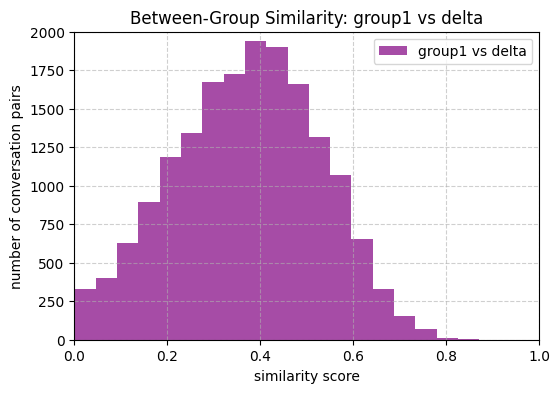

Between-Group Mean Similarity (group1 vs delta): 0.3699


In [20]:
group1_delta = between_group_similarity_check(random_2018_less_delta_set, delta_set, "group1", "delta", y_lim=2000)

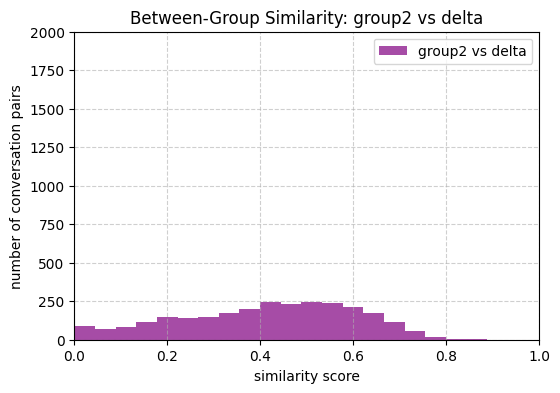

Between-Group Mean Similarity (group2 vs delta): 0.4144


In [21]:
group1_delta = between_group_similarity_check(random_2018_more_delta_set, delta_set, "group2", "delta", y_lim=2000)

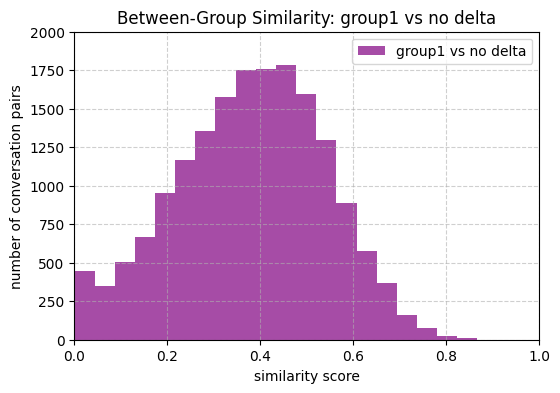

Between-Group Mean Similarity (group1 vs no delta): 0.3780


In [22]:
group1_delta = between_group_similarity_check(random_2018_less_delta_set, no_delta_set, "group1", "no delta", y_lim=2000)

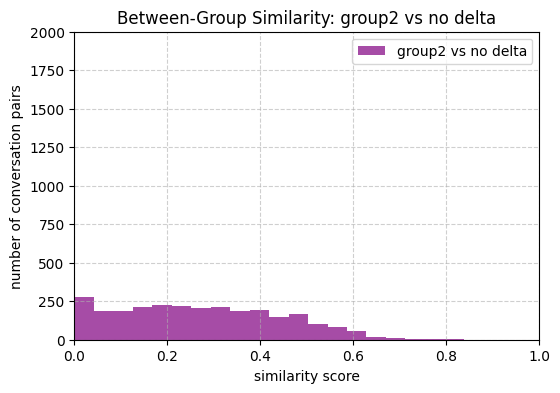

Between-Group Mean Similarity (group2 vs no delta): 0.2712


In [23]:
group1_delta = between_group_similarity_check(random_2018_more_delta_set, no_delta_set, "group2", "no delta", y_lim=2000)

#### Intra Group Similarity

Here we present the Intra group similarity within delta set and within no delta set

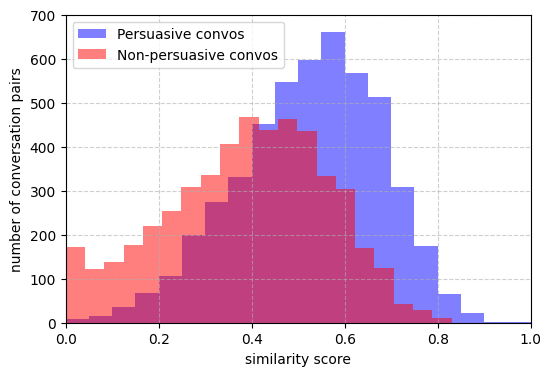

Mann-Whitney U statistic = 17571890.0, p-value = 0.00000
Persuasive Mean Similarity: 0.5242
Non-persuasive Mean Similarity: 0.3888
T-Test p-value (Are means different?): 0.0000
Levene's Test p-value (Is variance different?): 0.0000


In [31]:
two_groups_intra_group_similarity_check(delta_set, no_delta_set, "Persuasive", "Non-persuasive", all_convos, similarity_result, y_lim = 700)

# New Insights: Who Drives The Dynamics?

We investigate which speaker’s tendencies shape conversational dynamics by comparing conversations where the same individual appears as the original poster (OP) versus as the challenger. Using ConDynS, we quantify the similarity of dynamics across these role-specific conversations to assess whether situational power (held by the OP) or persuasive strategy (driven by the challenger) has a stronger influence on the interaction’s trajectory.

In [ ]:
corpus = Corpus(filename=DATA_PATH + "subreddit-changemyview")

In [4]:
### Annotate Delta
for utt in tqdm(corpus.iter_utterances()):
    if (
        utt.reply_to is not None
        and utt.speaker.id == "DeltaBot"
        and "delta awarded" in utt.text
    ):
        deltabot_text = utt.text
        match = re.search(
            r"(?:Confirmed: 1 delta awarded to )(?:\/)?(?:u\/)([\w-]+)", deltabot_text
        )
        if match is not None:
            try:
                delta_utt = corpus.get_utterance(utt.reply_to)
                delta_utt.meta['got_delta'] = True
            except KeyError:
                continue

5017556it [00:10, 496970.39it/s]


In [ ]:
BASE_PATH = "./artefacts"
CUR_ANALYSIS = "speaker_consistency_same_op_contender"

if not os.path.exists(f"{BASE_PATH}"):
    print("Making directory: ", f"{BASE_PATH}")
    os.makedirs(f"{BASE_PATH}")

if not os.path.exists(f"{BASE_PATH}/{CUR_ANALYSIS}/"):
    print("Making directory: ", f"{BASE_PATH}/{CUR_ANALYSIS}/")
    os.makedirs(f"{BASE_PATH}/{CUR_ANALYSIS}/")

In [6]:
def get_replier_id(utt_lst):
    return utt_lst[1].speaker.id

def get_op_id(utt_lst):
    return utt_lst[0].speaker.id

def get_rp_id(utt_lst):
    return utt_lst[1].speaker.id

def get_convo_id(utt_lst):
    return utt_lst[0].get_conversation().id

def get_convo_op_id(utt_lsts):
    return get_op_id(utt_lsts[0])

In [7]:
### First, we find all the valid two speaker threads that is at correct length 5+, for each conversation.
convo_to_two_speaker_threads = {}
for convo in tqdm(corpus.iter_conversations()):
    try:
        all_utt_lsts = convo.get_root_to_leaf_paths()
    except ValueError:
        continue

    valid_two_speaker_utt_lsts = []
    found_repliers = []
    for utt_lst in all_utt_lsts:
        if is_valid_convo(convo, utt_lst):
            replier = get_replier_id(utt_lst)
            if replier not in found_repliers:
                valid_two_speaker_utt_lsts.append(utt_lst)
                found_repliers.append(replier)
    if valid_two_speaker_utt_lsts:
        convo_to_two_speaker_threads[convo.id] = valid_two_speaker_utt_lsts

len(convo_to_two_speaker_threads)

117492it [00:42, 2797.24it/s]


31760

In [8]:
for convo_id, utt_lsts in convo_to_two_speaker_threads.items():
    op = get_convo_op_id(utt_lsts)
    for utt_lst in utt_lsts:
        assert get_op_id(utt_lst) == op

In [9]:
### we find all the times the speaker is whatever role
random.seed(4300)
sp_to_convos = {}
sp_to_convos_id = {}
for convo_id, utt_lsts in convo_to_two_speaker_threads.items():
    op = get_convo_op_id(utt_lsts)
    if op not in sp_to_convos_id.keys() or convo_id not in sp_to_convos_id[op]:
        if op not in sp_to_convos.keys():
            sp_to_convos[op] = []
        sp_to_convos[op].append(random.choice(utt_lsts))
        if op not in sp_to_convos_id.keys():
            sp_to_convos_id[op] = []
        sp_to_convos_id[op].append(convo_id)
    for utt_lst in utt_lsts:
        rp = get_rp_id(utt_lst)
        if op == rp: continue
        if rp not in sp_to_convos_id.keys() or convo_id not in sp_to_convos_id[rp]:
            if rp not in sp_to_convos.keys():
                sp_to_convos[rp] = []
            sp_to_convos[rp].append(utt_lst)
            if rp not in sp_to_convos_id.keys():
                sp_to_convos_id[rp] = []
            sp_to_convos_id[rp].append(convo_id)

enough_convo_sps = [sp for sp, lst in sp_to_convos.items() if len(lst) >= 2]
print(f"number of speakers with two or more conversations: {len(enough_convo_sps)}")
selected_convo_sps = random.sample(enough_convo_sps, 2000)
selected_convos_random_role = {}
for sp_id in selected_convo_sps:
    selection_lst = sp_to_convos[sp_id]
    assert len(selection_lst) >= 2
    if len(selection_lst) == 2:
        selected_convos_random_role.update({sp_id : selection_lst})
    else:
        selected_convos_random_role.update({sp_id : random.sample(selection_lst, 2)})
print(f"selected number of speakers to compare: {len(selected_convos_random_role)}")

### Ensure no repeated convo selected for the same speaker
for sp_id, utt_lsts in selected_convos_random_role.items():
    assert len(utt_lsts) == 2
    assert utt_lsts[0][0].get_conversation().id != utt_lsts[1][0].get_conversation().id 

number of speakers with two or more conversations: 9964
selected number of speakers to compare: 2000


In [10]:
### we find all the times the speaker is OP
random.seed(4300)
sp_op_convos = {}
sp_op_to_convos_id = {}
for convo_id, utt_lsts in convo_to_two_speaker_threads.items():
    op = get_convo_op_id(utt_lsts)
    if op not in sp_op_to_convos_id.keys() or convo_id not in sp_op_to_convos_id[op]:
        if op not in sp_op_convos.keys():
            sp_op_convos[op] = []
        sp_op_convos[op].append(random.choice(utt_lsts))
        if op not in sp_op_to_convos_id.keys():
            sp_op_to_convos_id[op] = []
        sp_op_to_convos_id[op].append(convo_id)

enough_convo_sps = [op for op, lst in sp_op_convos.items() if len(lst) >= 2]
print(f"number of speakers with two or more OP conversations: {len(enough_convo_sps)}")
selected_convo_sps = random.sample(enough_convo_sps, 2000)
selected_convos_op_role = {sp_id : random.sample(sp_op_convos[sp_id], 2) for sp_id in selected_convo_sps}
print(f"selected number of speakers to compare: {len(selected_convos_op_role)}")

### Ensure no repeated convo selected for the same speaker
for sp_id, utt_lsts in selected_convos_op_role.items():
    assert len(utt_lsts) == 2
    assert utt_lsts[0][0].get_conversation().id != utt_lsts[1][0].get_conversation().id 

number of speakers with two or more OP conversations: 3964
selected number of speakers to compare: 2000


In [11]:
### we find all the times the speaker is RP
random.seed(4300)
sp_rp_convos = {}
sp_rp_to_convos_id = {}
for convo_id, utt_lsts in convo_to_two_speaker_threads.items():
    for utt_lst in utt_lsts:
        rp = get_rp_id(utt_lst)
        if rp not in sp_rp_to_convos_id.keys() or convo_id not in sp_rp_to_convos_id[rp]:
            if rp not in sp_rp_convos.keys():
                sp_rp_convos[rp] = []
            sp_rp_convos[rp].append(utt_lst)
            if rp not in sp_rp_to_convos_id.keys():
                sp_rp_to_convos_id[rp] = []
            sp_rp_to_convos_id[rp].append(convo_id)

enough_convo_sps = [rp for rp, lst in sp_rp_convos.items() if len(lst) >= 2]
print(f"number of speakers with two or more RP conversations: {len(enough_convo_sps)}")
selected_convo_sps = random.sample(enough_convo_sps, 2000)
selected_convos_rp_role = {sp_id : random.sample(sp_rp_convos[sp_id], 2) for sp_id in selected_convo_sps}
print(f"selected number of speakers to compare: {len(selected_convos_rp_role)}")

### Ensure no repeated convo selected for the same speaker
for sp_id, utt_lsts in selected_convos_rp_role.items():
    assert len(utt_lsts) == 2
    assert utt_lsts[0][0].get_conversation().id != utt_lsts[1][0].get_conversation().id 

number of speakers with two or more RP conversations: 6120
selected number of speakers to compare: 2000


In [ ]:
def get_cur_convo_transcript(utt_lst):
    transcription = []
    spk_list = {utt_lst[0].speaker.id : "SPEAKER1"}
    for utt in utt_lst:
        if utt.speaker.id not in spk_list.keys():
            spk_list[utt.speaker.id] = "SPEAKER2"
            assert len(spk_list) == 2
        transcription.append(spk_list[utt.speaker.id] +": "+utt.text)
    transcription = transcription[1:] ### truncate OP first message
    return transcription
    
def get_bidirection_similarity_with_retry_utt_lst(corpus, convo1_id, convo2_id, utt_lst_1, utt_lst_2, summaries_and_bullets, incomplete, retries=10):
    transcript1 = get_cur_convo_transcript(utt_lst_1)
    transcript2 = get_cur_convo_transcript(utt_lst_2)
    
    scd1 = summaries_and_bullets[convo1_id]['summary']
    scd2 = summaries_and_bullets[convo2_id]['summary']
    
    for i in range(retries):
        try:
            result = condyns_gpt.compute_bidirectional_similarity(transcript1, transcript2, scd1, scd2)
            score = condyns_gpt.compute_score_from_results(result)
            return score, result, incomplete
        except Exception as e:
            wait = 0.5 ** i + random.random()
            print(f"Retrying ({convo1_id}, {convo2_id}) after {wait:.2f}s due to error: {e}")
            incomplete.update(f'{convo1_id}_{convo2_id}')
            time.sleep(wait)
    return None, None, incomplete

In [ ]:
def split_dict(d, n):
    items = list(d.items())
    chunk_size = math.ceil(len(items) / n)
    return [dict(items[i:i + chunk_size]) for i in range(0, len(items), chunk_size)]

# === Config and setup ===
all_need_to_compares = [selected_convos_rp_role, selected_convos_op_role, selected_convos_random_role]
all_ROLE = ["RP", "OP", "RANDOM_ROLE"]

for ROLE, need_to_compares in zip(all_ROLE, all_need_to_compares):
    SAVE_PATH = f"{BASE_PATH}/{CUR_ANALYSIS}/{ROLE}"
    os.makedirs(SAVE_PATH, exist_ok=True)
    
    # === Load previously saved data ===
    def load_json(path, default):
        return json.load(open(path)) if os.path.exists(path) else default
    
    summaries_and_bullets = load_json(f"{SAVE_PATH}/summary.json", {})
    similarity_result = load_json(f"{SAVE_PATH}/similarity.json", {})
    incomplete = set(load_json(f"{SAVE_PATH}/incomplete.json", []))
    
    # === Worker Function ===
    def process_chunk(chunk):
        local_summaries = {}
        local_similarity = {}
        local_incomplete = set()
    
        for sp_id, (utt_lst1, utt_lst2) in chunk.items():
            id1 = f"{sp_id}##{utt_lst1[0].get_conversation().id}"
            id2 = f"{sp_id}##{utt_lst2[0].get_conversation().id}"
    
            for idx, utt_lst in zip([id1, id2], [utt_lst1, utt_lst2]):
                if idx in summaries_and_bullets:
                    continue
                summary, bulletpoint = persuasion_scd_writer.get_scd_and_sop(corpus, utt_lst)
                local_summaries[idx] = {"summary": summary, "bulletpoint": bulletpoint}
    
            id_pair_key_1 = f'{id1}_{id2}'
            id_pair_key_2 = f'{id2}_{id1}'
    
            if id_pair_key_1 not in similarity_result and id_pair_key_1 not in incomplete \
               and id_pair_key_2 not in similarity_result and id_pair_key_2 not in incomplete:
                score, result, inc = get_bidirection_similarity_with_retry_utt_lst(corpus, id1, id2, utt_lst1, utt_lst2, summaries_and_bullets, incomplete)
                local_similarity[id_pair_key_1] = {"score": score, "result": result}
                local_incomplete.update(inc)
    
        return local_summaries, local_similarity, local_incomplete
    
    # === Split work and run with threads ===
    NUM_WORKERS = 25
    chunks = split_dict(need_to_compares, NUM_WORKERS)
    
    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        futures = [executor.submit(process_chunk, chunk) for chunk in chunks]
    
        for future in tqdm(as_completed(futures), total=len(futures)):
            local_summaries, local_similarity, local_incomplete = future.result()
            summaries_and_bullets.update(local_summaries)
            similarity_result.update(local_similarity)
            incomplete.update(local_incomplete)
    
    # === Save to files ===
    with open(f"{SAVE_PATH}/summary.json", "w") as file:
        json.dump(summaries_and_bullets, file, indent=4)
    
    with open(f"{SAVE_PATH}/similarity.json", "w") as file:
        json.dump(similarity_result, file, indent=4)
    
    with open(f"{SAVE_PATH}/incomplete.json", "w") as file:
        json.dump(list(incomplete), file, indent=4)

In [ ]:
need_to_compares = selected_convos_rp_role # selected_convos_op_role # selected_convos_random_role
ROLE = "RP" # "OP" # "RANDOM_ROLE"
SAVE_PATH = f"{BASE_PATH}/{CUR_ANALYSIS}/{ROLE}"

with open(f"{SAVE_PATH}/similarity.json", "r") as file:
    similarity_result_rp = json.load(file)

RP_similarity = []

for sp_id, (utt_lst1, utt_lst2) in need_to_compares.items():
    id1 = f"{sp_id}##{utt_lst1[0].get_conversation().id}"
    id2 = f"{sp_id}##{utt_lst2[0].get_conversation().id}"
            
    sim_key = f'{id1}_{id2}' if f'{id1}_{id2}' in similarity_result_rp.keys() else f'{id2}_{id1}'
    assert sim_key in similarity_result_rp.keys()
    try:
        RP_similarity.append(np.mean(similarity_result_rp[sim_key]['score']))
    except TypeError:
        print(similarity_result_rp[sim_key]['score'])
        

need_to_compares = selected_convos_op_role 
ROLE = "OP" # "RP" # "RANDOM_ROLE"
SAVE_PATH = f"{BASE_PATH}/{CUR_ANALYSIS}/{ROLE}"

with open(f"{SAVE_PATH}/similarity.json", "r") as file:
    similarity_result_op = json.load(file)

OP_similarity = []

for sp_id, (utt_lst1, utt_lst2) in need_to_compares.items():
    id1 = f"{sp_id}##{utt_lst1[0].get_conversation().id}"
    id2 = f"{sp_id}##{utt_lst2[0].get_conversation().id}"
            
    sim_key = f'{id1}_{id2}' if f'{id1}_{id2}' in similarity_result_op.keys() else f'{id2}_{id1}'
    assert sim_key in similarity_result_op.keys()
    OP_similarity.append(np.mean(similarity_result_op[sim_key]['score']))


need_to_compares = selected_convos_random_role
ROLE = "RANDOM_ROLE" # "RP" # "OP"
SAVE_PATH = f"{BASE_PATH}/{CUR_ANALYSIS}/{ROLE}"

with open(f"{SAVE_PATH}/similarity.json", "r") as file:
    similarity_result_random = json.load(file)

RANDOM_similarity = []

for sp_id, (utt_lst1, utt_lst2) in need_to_compares.items():
    id1 = f"{sp_id}##{utt_lst1[0].get_conversation().id}"
    id2 = f"{sp_id}##{utt_lst2[0].get_conversation().id}"
            
    sim_key = f'{id1}_{id2}' if f'{id1}_{id2}' in similarity_result_random.keys() else f'{id2}_{id1}'
    assert sim_key in similarity_result_random.keys()
    try:
        RANDOM_similarity.append(np.mean(similarity_result_random[sim_key]['score']))
    except TypeError:
        # print(similarity_result_random[sim_key]['score'])
        pass # checked that only one doesn't work


In [18]:
round(np.mean(RANDOM_similarity), 4), round(np.mean(OP_similarity), 4), round(np.mean(RP_similarity), 4)

(0.3895, 0.4057, 0.3946)

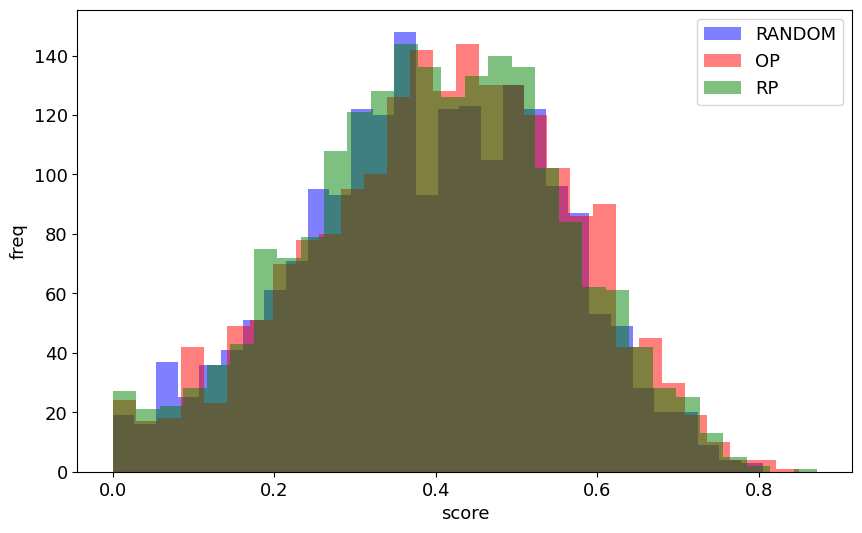

RANDOM:
  Mean: 0.3895
  Median: 0.395
OP:
  Mean: 0.4057
  Median: 0.4143
RP:
  Mean: 0.3946
  Median: 0.3987


In [19]:
plt.figure(figsize=(10, 6))
plt.hist(RANDOM_similarity, bins=30, alpha=0.5, label=f'RANDOM', color='blue', density=False)
plt.hist(OP_similarity, bins=30, alpha=0.5, label=f'OP', color='red', density=False)
plt.hist(RP_similarity, bins=30, alpha=0.5, label=f'RP', color='green', density=False)


plt.xlabel('score')
plt.ylabel('freq')
plt.legend()
# plt.tight_layout()
plt.show()
print(f"RANDOM:")
print("  Mean:", round(np.mean(RANDOM_similarity), 4))
print("  Median:", round(np.median(RANDOM_similarity), 4))
print(f"OP:")
print("  Mean:", round(np.mean(OP_similarity), 4))
print("  Median:", round(np.median(OP_similarity), 4))
print(f"RP:")
print("  Mean:", round(np.mean(RP_similarity), 4))
print("  Median:", round(np.median(RP_similarity), 4))


In [20]:
t_stat, p_value = stats.ttest_ind(OP_similarity, RP_similarity, equal_var=False)
print(f"T-Test p-value (Are means different?): {p_value}")

T-Test p-value (Are means different?): 0.02807955912400292


In [27]:
stat, p_value = mannwhitneyu(RP_similarity, RANDOM_similarity, alternative='two-sided')
print(f"Mann Whitney statistic: {stat}")
print(f"p-value: {p_value}")

Mann Whitney statistic: 2030930.5
p-value: 0.38175942152805065
